# Интегрирование обыкновенных дифференциальных уравнений в среде Python на примере баллистического движения точки с учетом сопротивления атмосферы

Юдинцев В. В. 2024

[https://classmech.ru](https://classmech.ru)

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from collections import namedtuple

# Уравнения движения

Уравнение баллистики в векторной форме

$$
\frac{d^2\vec{r}}{dt^2} = m\vec{g} + \vec{F}_a
$$

где $\vec{F}_a$ - аэродинамическая сила

$$ \vec{F}_a = - \frac{\vec v}{|\vec v|}  C_x S_m \frac{\rho v^2}{2}  $$

Матричная запись уравнений

$$
    \begin{bmatrix} \ddot x \\ \ddot y \end{bmatrix} = \begin{bmatrix} 0 \\ - m g \end{bmatrix} - \begin{bmatrix} \dot x \\ \dot y \end{bmatrix} \frac{1}{\sqrt{\dot x^2+\dot y^2}} C_x S_m (\dot x^2+\dot y^2)
$$

Система уравнений первого прорядка

$$
    \begin{bmatrix} \dot x \\ \dot y \\ \dot v_x \\ \dot v_y \end{bmatrix} = \begin{bmatrix} v_x \\ v_y \\ -\dot x \frac{1}{\sqrt{\dot x^2+\dot y^2}} C_x S_m (\dot x^2+\dot y^2) \\ - m g - \dot y \frac{1}{\sqrt{\dot x^2+\dot y^2}} C_x S_m (\dot x^2+\dot y^2) \end{bmatrix} 
$$

# Функция правых частей

In [241]:
def dydt(t, q):     
    r = q[0:2];  # Положение 
    v = q[2:4];  # Скорость
    # Масса тела 
    m = 5;
    # Ускорение свободного падения
    g = 9.807
    # Аэродинамический коэффициент лобового сопротивления
    Cx = 1.0;
    # Характерная площадь шарик диаметром 0.2 м
    Sm = np.pi*0.2**2/4;
    # Плотность воздуха
    rho = 1.2;    
    # Скоростной напор    
    dynamic_pressure = rho*np.dot(v,v)*0.5;   
    # Аэродинамическая сила
    Fa = -v/np.sqrt(np.dot(v,v))*Cx*Sm*dynamic_pressure;
    # Сила тяжести
    G = np.array([0,-m*g]);
    # Координатный столбец главного вектора сил, действующего на тело
    F = G + Fa;
    # Ускорение
    a = F/m;    
    return np.hstack([v,a])    

Начальные условия

In [242]:
v0     = 30
phi0   = np.deg2rad(45)
r0_vec = [0,0]
v0_vec = [v0*np.cos(phi0),v0*np.sin(phi0)]
q0     = np.hstack([r0_vec,v0_vec])
q0

array([ 0.        ,  0.        , 21.21320344, 21.21320344])

Решение

In [243]:
sol = solve_ivp(dydt, [0, 5], q0, method='RK45', rtol = 1e-8)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.445e-02 ...  4.370e+00  5.000e+00]
        y: [[ 0.000e+00  3.064e-01 ...  7.775e+01  8.683e+01]
            [ 0.000e+00  3.053e-01 ... -6.369e+00 -2.127e+01]
            [ 2.121e+01  2.118e+01 ...  1.489e+01  1.394e+01]
            [ 2.121e+01  2.104e+01 ... -2.131e+01 -2.593e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 74
     njev: 0
      nlu: 0

Text(0, 0.5, 'y, м')

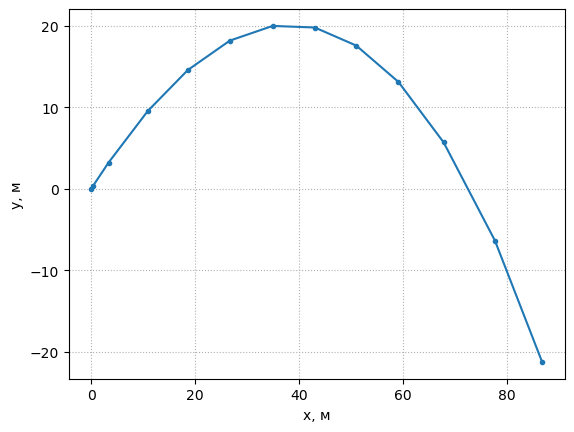

In [244]:
plt.plot(sol.y[0],sol.y[1],'.-')
plt.grid(ls=':')
plt.xlabel('x, м')
plt.ylabel('y, м')

Ограничиваем максимальный шаг **max_step**, чтобы график стал более "гладким"

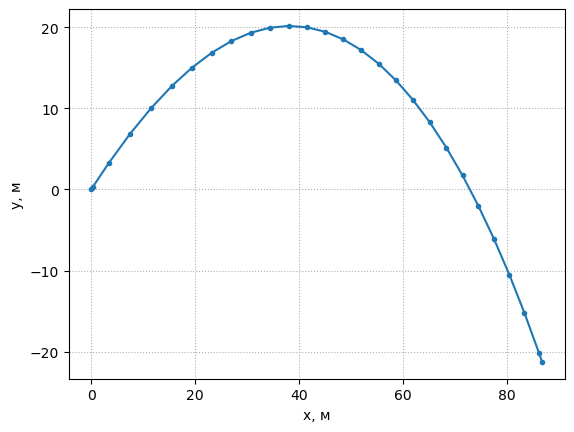

In [245]:
sol = solve_ivp(dydt, [0, 5], q0, method='RK45', max_step = 0.2, rtol = 1e-8)

plt.plot(sol.y[0],sol.y[1],'.-')
plt.grid(ls=':')
plt.xlabel('x, м')
plt.ylabel('y, м');

# Остановка процесса интегрирования по условию

In [246]:
def event_h_eq_0(t, q):
  # Функция-"детектор", передаваемая в интегратор (параметр events), 
  # для определения времени достижения нулевой высоты и 
  # остановки процесса интегрирования      
  # Возвращаем высоту (контролируемая функция)
  return q[1]  

# функция-детектор срабатывает при условии h = 0 при движении "вниз" (при убывании контролируемой функции) 
event_h_eq_0.direction = -1
# функция-детектор останавливает процесс
event_h_eq_0.terminal  = True  

In [247]:
sol = solve_ivp(dydt, [0, 5], q0, method='RK45', rtol = 1e-8, max_step = 0.2, events = [event_h_eq_0])

Text(0, 0.5, 'y, м')

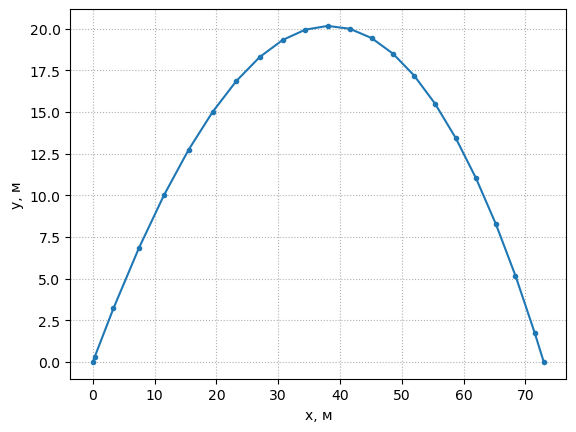

In [248]:
plt.plot(sol.y[0],sol.y[1],'.-')
plt.grid(ls=':')
plt.xlabel('x, м')
plt.ylabel('y, м')

Время события (событий) -- срабатывание фукции-детектора

In [249]:
sol.t_events 

[array([4.05280149])]

Вектор состояния в момент срабатывания фукции-детектора

In [250]:
sol.y_events 

[array([[ 7.29516740e+01,  1.33226763e-14,  1.53460271e+01,
         -1.88024764e+01]])]

## Параметры модели в отдельной структуре

### Именованный кортеж

In [252]:
p = namedtuple("params", "m Cx rho Sm g")

# Масса
p.m = 5;
# Ускорение свободного падения
p.g = 9.807
# Аэродинамический коэффициент лобового сопротивления
p.Cx = 1.0;
# Характерная площадь
p.Sm = np.pi*0.2**2/4
# Плотность воздуха
p.rho = 1.2  

# Функция правых частей
def dydt(t, q, p):     
    r = q[0:2];    
    v = q[2:4];
    # Скоростной напор    
    dynamic_pressure = p.rho*np.dot(v,v)*0.5;   
    # Аэродинамическая сила
    Fa = -v/np.sqrt(np.dot(v,v))*p.Cx*p.Sm*dynamic_pressure;
    # Сила тяжести
    G = np.array([0,-p.m*p.g]);
    # Координатный столбец главного вектора сил, действующего на тело
    F = G + Fa;
    # Ускорение
    a = F/p.m;
    return np.hstack([v,a])    


In [253]:
sol = solve_ivp(lambda t,q: dydt(t,q,p), [0, 5], q0, method='RK45', rtol = 1e-8, max_step = 0.2, events = [event_h_eq_0])

Text(0, 0.5, 'y, м')

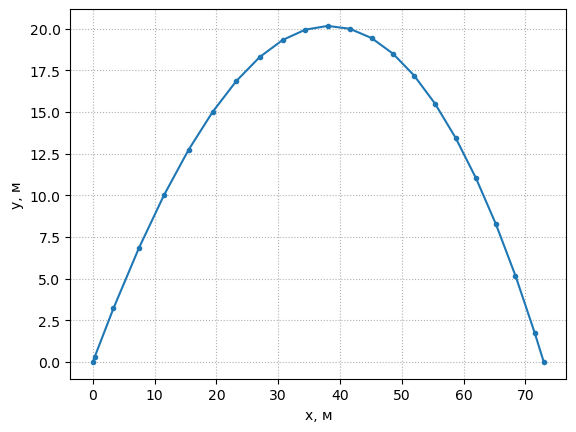

In [254]:
plt.plot(sol.y[0],sol.y[1],'.-')
plt.grid(ls=':')
plt.xlabel('x, м')
plt.ylabel('y, м')

Исследуем влияние сопротивления воздуха на движение

In [255]:
# Сопротивления нет
p.Cx = 0
sol1 = solve_ivp(lambda t,q: dydt(t,q,p), [0, 5], q0, method='RK45', rtol = 1e-8, max_step = 0.2, events = [event_h_eq_0])

# Сопротивления есть
p.Cx = 1
sol2 = solve_ivp(lambda t,q: dydt(t,q,p), [0, 5], q0, method='RK45', rtol = 1e-8, max_step = 0.2, events = [event_h_eq_0])

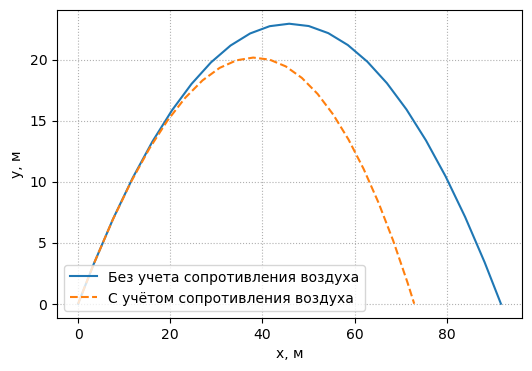

In [289]:
plt.figure(figsize=[6,4])
plt.plot(sol1.y[0],sol1.y[1],'-')
plt.plot(sol2.y[0],sol2.y[1],'--',)
plt.grid(ls=':')
plt.xlabel('x, м')
plt.ylabel('y, м')
plt.legend(['Без учета сопротивления воздуха','С учётом сопротивления воздуха'], loc = 'lower left')

### Используем ообъект типа DataClass

In [52]:
from dataclasses import dataclass

In [257]:
@dataclass
class Data:
    # Масса маятника
    m : float = 5;
    # Ускорение свободного падения
    g : float = 9.807;
    # Аэродинамический коэффициент лобового сопротивления
    Cx : float =  1.0  
    # Характерная площадь
    Sm : float = np.pi*0.2**2/4
    # Плотность воздуха
    rho : float = 1.2

# Создаем экземпляр класса Data (объект)
p = Data()

In [258]:
sol = solve_ivp(lambda t,q: dydt(t,q,p), [0, 5], q0, method='RK45', rtol = 1e-8, max_step = 0.2, events = [event_h_eq_0])

Text(0, 0.5, 'y, м')

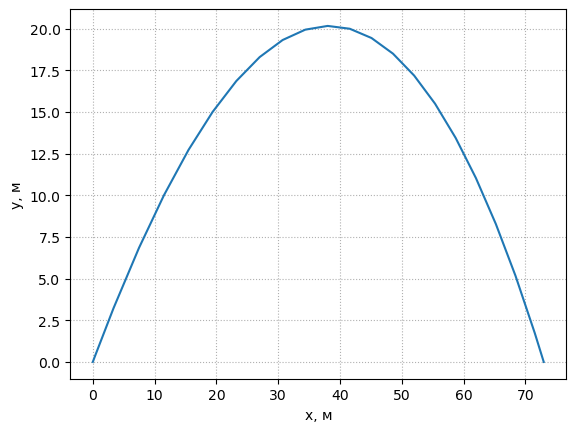

In [259]:
plt.plot(sol.y[0],sol.y[1])
plt.grid(ls=':')
plt.xlabel('x, м')
plt.ylabel('y, м')

# Моделируем отскок от поверхности

In [260]:
q0

array([ 0.        ,  0.        , 21.21320344, 21.21320344])

In [271]:
q0 = np.hstack([r0_vec,v0_vec])
t  = list()
q  = list()
for i in range(5):
    s = solve_ivp(lambda t,q: dydt(t,q,p), [0, 5], q0, method='RK45', rtol = 1e-8, max_step = 0.2, events = [event_h_eq_0])
    t.append(s.t)    
    q.append(s.y) 
    q0 = s.y_events[0].ravel()*np.array([1,1,1,-1])    

Объединяем таблицы решений в один массив

In [272]:
t = np.hstack(t)
q = np.hstack(q)

Text(0, 0.5, 'y, м')

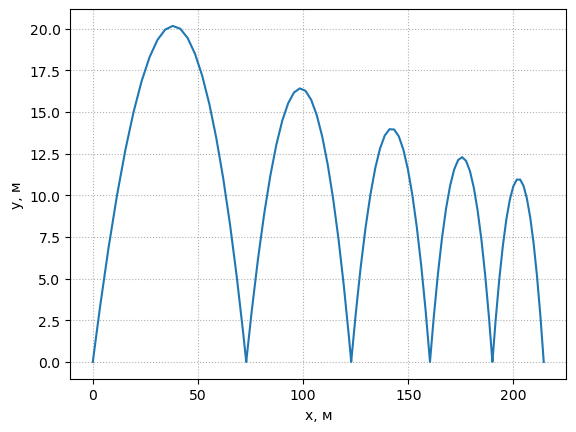

In [273]:
plt.plot(q[0],q[1])
plt.grid(ls=':')
plt.xlabel('x, м')
plt.ylabel('y, м')

## Зависимость дальности от начального угла наклона траектории при постоянной скорости

In [274]:
def dist_v_phi(v, phi, Cx):
    v0     = v
    phi0   = phi;
    r0_vec = [0,0]
    v0_vec = [v0*np.cos(phi0),v0*np.sin(phi0)]
    q0     = np.hstack([r0_vec,v0_vec])    
    p.Cx   = Cx
    sol = solve_ivp(lambda t,q: dydt(t,q,p), [0, 30], q0, method='RK45', rtol = 1e-8, max_step = 0.2, events = [event_h_eq_0])
    return sol.y_events[0][0,0]

In [275]:
dist_v_phi(30,np.deg2rad(45),1.0)

72.95167404444148

In [276]:
phi_dist = np.array([ [phi, dist_v_phi(30,phi,0.0), dist_v_phi(30,phi,1.0)] for phi in np.linspace(np.deg2rad(10),np.deg2rad(90),20)])
phi_dist

array([[1.74532925e-01, 3.13875935e+01, 2.91191974e+01],
       [2.48020473e-01, 4.36782557e+01, 3.94079396e+01],
       [3.21508020e-01, 5.50270916e+01, 4.84005933e+01],
       [3.94995568e-01, 6.51893882e+01, 5.60410851e+01],
       [4.68483115e-01, 7.39460177e+01, 6.22907964e+01],
       [5.41970662e-01, 8.11081624e+01, 6.71253597e+01],
       [6.15458210e-01, 8.65213865e+01, 7.05324141e+01],
       [6.88945757e-01, 9.00689654e+01, 7.25101730e+01],
       [7.62433305e-01, 9.16744034e+01, 7.30666888e+01],
       [8.35920852e-01, 9.13030827e+01, 7.22197326e+01],
       [9.09408400e-01, 8.89630100e+01, 6.99972414e+01],
       [9.82895947e-01, 8.47046439e+01, 6.64383127e+01],
       [1.05638349e+00, 7.86198068e+01, 6.15947504e+01],
       [1.12987104e+00, 7.08397049e+01, 5.55331787e+01],
       [1.20335859e+00, 6.15320991e+01, 4.83377470e+01],
       [1.27684614e+00, 5.08976878e+01, 4.01134411e+01],
       [1.35033368e+00, 3.91657787e+01, 3.09900119e+01],
       [1.42382123e+00, 2.65893

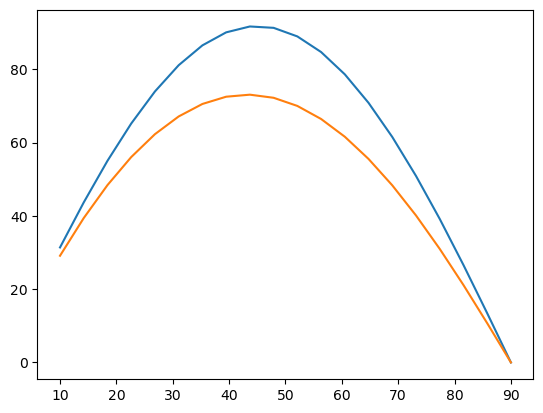

In [277]:
plt.plot(np.rad2deg(phi_dist[:,0]),phi_dist[:,1],np.rad2deg(phi_dist[:,0]), phi_dist[:,2])

## Зависимость угла максимальной дальности от Cx
Использование функции minimize

In [278]:
def dist_v_phi(v, phi, Cx):    
    v0     = v
    phi0   = phi;
    r0_vec = [0,0]
    v0_vec = [v0*np.cos(phi0),v0*np.sin(phi0)]
    q0     = np.hstack([r0_vec,v0_vec])    
    p.Cx   = Cx
    sol = solve_ivp(lambda t,q: dydt(t,q,p), [0, 50], q0, method='RK45', rtol = 1e-8, max_step = 0.1, events = [event_h_eq_0])
    return sol.y_events[0][0,0]

dist_v_phi(30,np.deg2rad(45),1.0)

72.95167404616701

In [279]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [280]:
minimize(lambda x: -dist_v_phi(30, x[0], 1.0), np.deg2rad(30.0), bounds = Bounds(lb=0.1, ub=1.5))

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -73.07458945819477
        x: [ 7.546e-01]
      nit: 4
      jac: [-1.421e-06]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [281]:
dist_max_Cx = lambda Cx: minimize(lambda x: -dist_v_phi(50, x[0], Cx), np.deg2rad(30.0), bounds = Bounds(lb=0.0, ub=np.pi/2)).x

dist_max_Cx(0)

array([0.78539819])

In [282]:
dist_max_Cx(1.0)

array([0.71710789])

In [283]:
Cx_phi_dist_max = np.array([ (Cx, dist_max_Cx(Cx)[0]) for Cx in np.linspace(0,2,10) ])
Cx_phi_dist_max

array([[0.        , 0.78539819],
       [0.22222222, 0.76525605],
       [0.44444444, 0.74869452],
       [0.66666667, 0.73468562],
       [0.88888889, 0.72258394],
       [1.11111111, 0.71195849],
       [1.33333333, 0.70250755],
       [1.55555556, 0.69401198],
       [1.77777778, 0.68630776],
       [2.        , 0.67926902]])

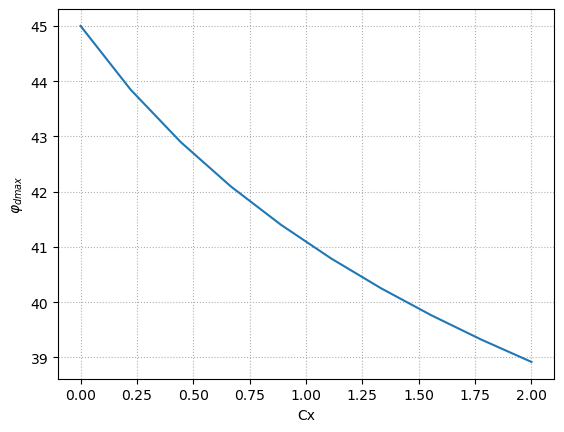

In [284]:
plt.plot(Cx_phi_dist_max[:,0],Cx_phi_dist_max[:,1]*180/np.pi)
plt.xlabel('Cx')
plt.ylabel('$\\varphi_{dmax}$');
plt.grid(ls=':')